# Project Development Notebook 
## Project group name: Lamaceratops_Salsa_Largo
#### Project group members: Jaweria Amjad, Albert Berdjour, Gerald Yiran, Timon Kunze
#### Pod TA: Nazimur Rashid Chowdhury
#### Project TA: Wil Laura

In [1]:
# You can start coding here
from IPython.display import IFrame
link_id = "wx7tu"

In [2]:
# imports
import time
tic = time.time()
from scipy.ndimage.measurements import label
import sys
import pandas as pd
import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import pyleoclim as pyleo

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot
import geoviews as gv
import holoviews
from geoviews import Dataset as gvDataset
import geoviews.feature as gf
from geoviews import Image as gvImage

from datatree import DataTree
from xmip.postprocessing import _parse_metric
import cartopy as cart
import cartopy.crs as ccrs
import random
import pooch
import os
import tempfile

import geopy
import geopy.distance
import datetime
from datetime import date, timedelta

/tmp/ipykernel_3484/4104914918.py:4: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [3]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/Heatwaves' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file


In [4]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}
%matplotlib inline

## CMIP6: 

We will utilize a CMIP6 dataset to examine trends in surface temperature, precipitation and soil moisture on heatwaves.

Specifically, in this project we will will analyze data from a model and examine its historical temperature records.

In [5]:
# loading CMIP data

col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# There are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ['MPI-ESM1-2-LR']#['MRI-ESM2-0']
variable_ids = ["tas"]#["tas", "pr"]
# sorted(col.df["source_id"].unique())



### Fetch data

In [6]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id= variable_ids,
    member_id="r1i1p1f1",
    table_id="3hr",
    grid_label="gn",
    experiment_id=["historical"],  # add scenarios if interested in projection
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt = cat.to_datatree(**kwargs)
dt


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


DataTree('None', parent=None)
└── DataTree('MPI-ESM1-2-LR')
    └── DataTree('historical')
            Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 482120, y: 96,
                                 x: 192, bnds: 2, vertex: 4)
            Coordinates:
                height          float64 2.0
              * y               (y) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
              * x               (x) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
              * time            (time) object 1850-01-01 03:00:00 ... 2015-01-01 00:00:00
                lat_bounds      (y, bnds, x) float64 dask.array<chunksize=(96, 2, 192), meta=np.ndarray>
                lon_bounds      (x, bnds, y) float64 dask.array<chunksize=(192, 2, 96), meta=np.ndarray>
                lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.1 358.1 358.1
                lat             (x, y) float64 -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
                lon_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 192, 96), meta=np.ndarray>
                lat_verticies   (vertex, x, y) float64 dask.array<chunksize=(1, 192, 96), meta=np.ndarray>
              * member_id       (member_id) object 'r1i1p1f1'
              * dcpp_init_year  (dcpp_init_year) float64 nan
            Dimensions without coordinates: bnds, vertex
            Data variables:
                tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 1456, 96, 192), meta=np.ndarray>
            Attributes: (12/63)
                Conventions:                      CF-1.7 CMIP-6.2
                activity_id:                      CMIP
                branch_method:                    standard
                branch_time_in_child:             0.0
                branch_time_in_parent:            0.0
                cmor_version:                     3.5.0
                ...                               ...
                intake_esm_attrs:variable_id:     tas
                intake_esm_attrs:grid_label:      gn
                intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-...
                intake_esm_attrs:version:         20190710
                intake_esm_attrs:_data_format_:   zarr
                intake_esm_dataset_key:           MPI-ESM1-2-LR/historical

In [7]:
# select just a single model and experiment
tas_historical = dt[source_ids[0]]["historical"].ds.tas
print("The time range is:")
print(
    tas_historical.time[0].data.astype("M8[h]"),
    "to",
    tas_historical.time[-1].data.astype("M8[h]"),
)

The time range is:
1850-01-01T03 to 2015-01-01T00


### Q1: Plot the worldwide near surface temperature distribution (map) for four example years using the CMIP6 dataset.

Text(0.5, 1.0, '2010')

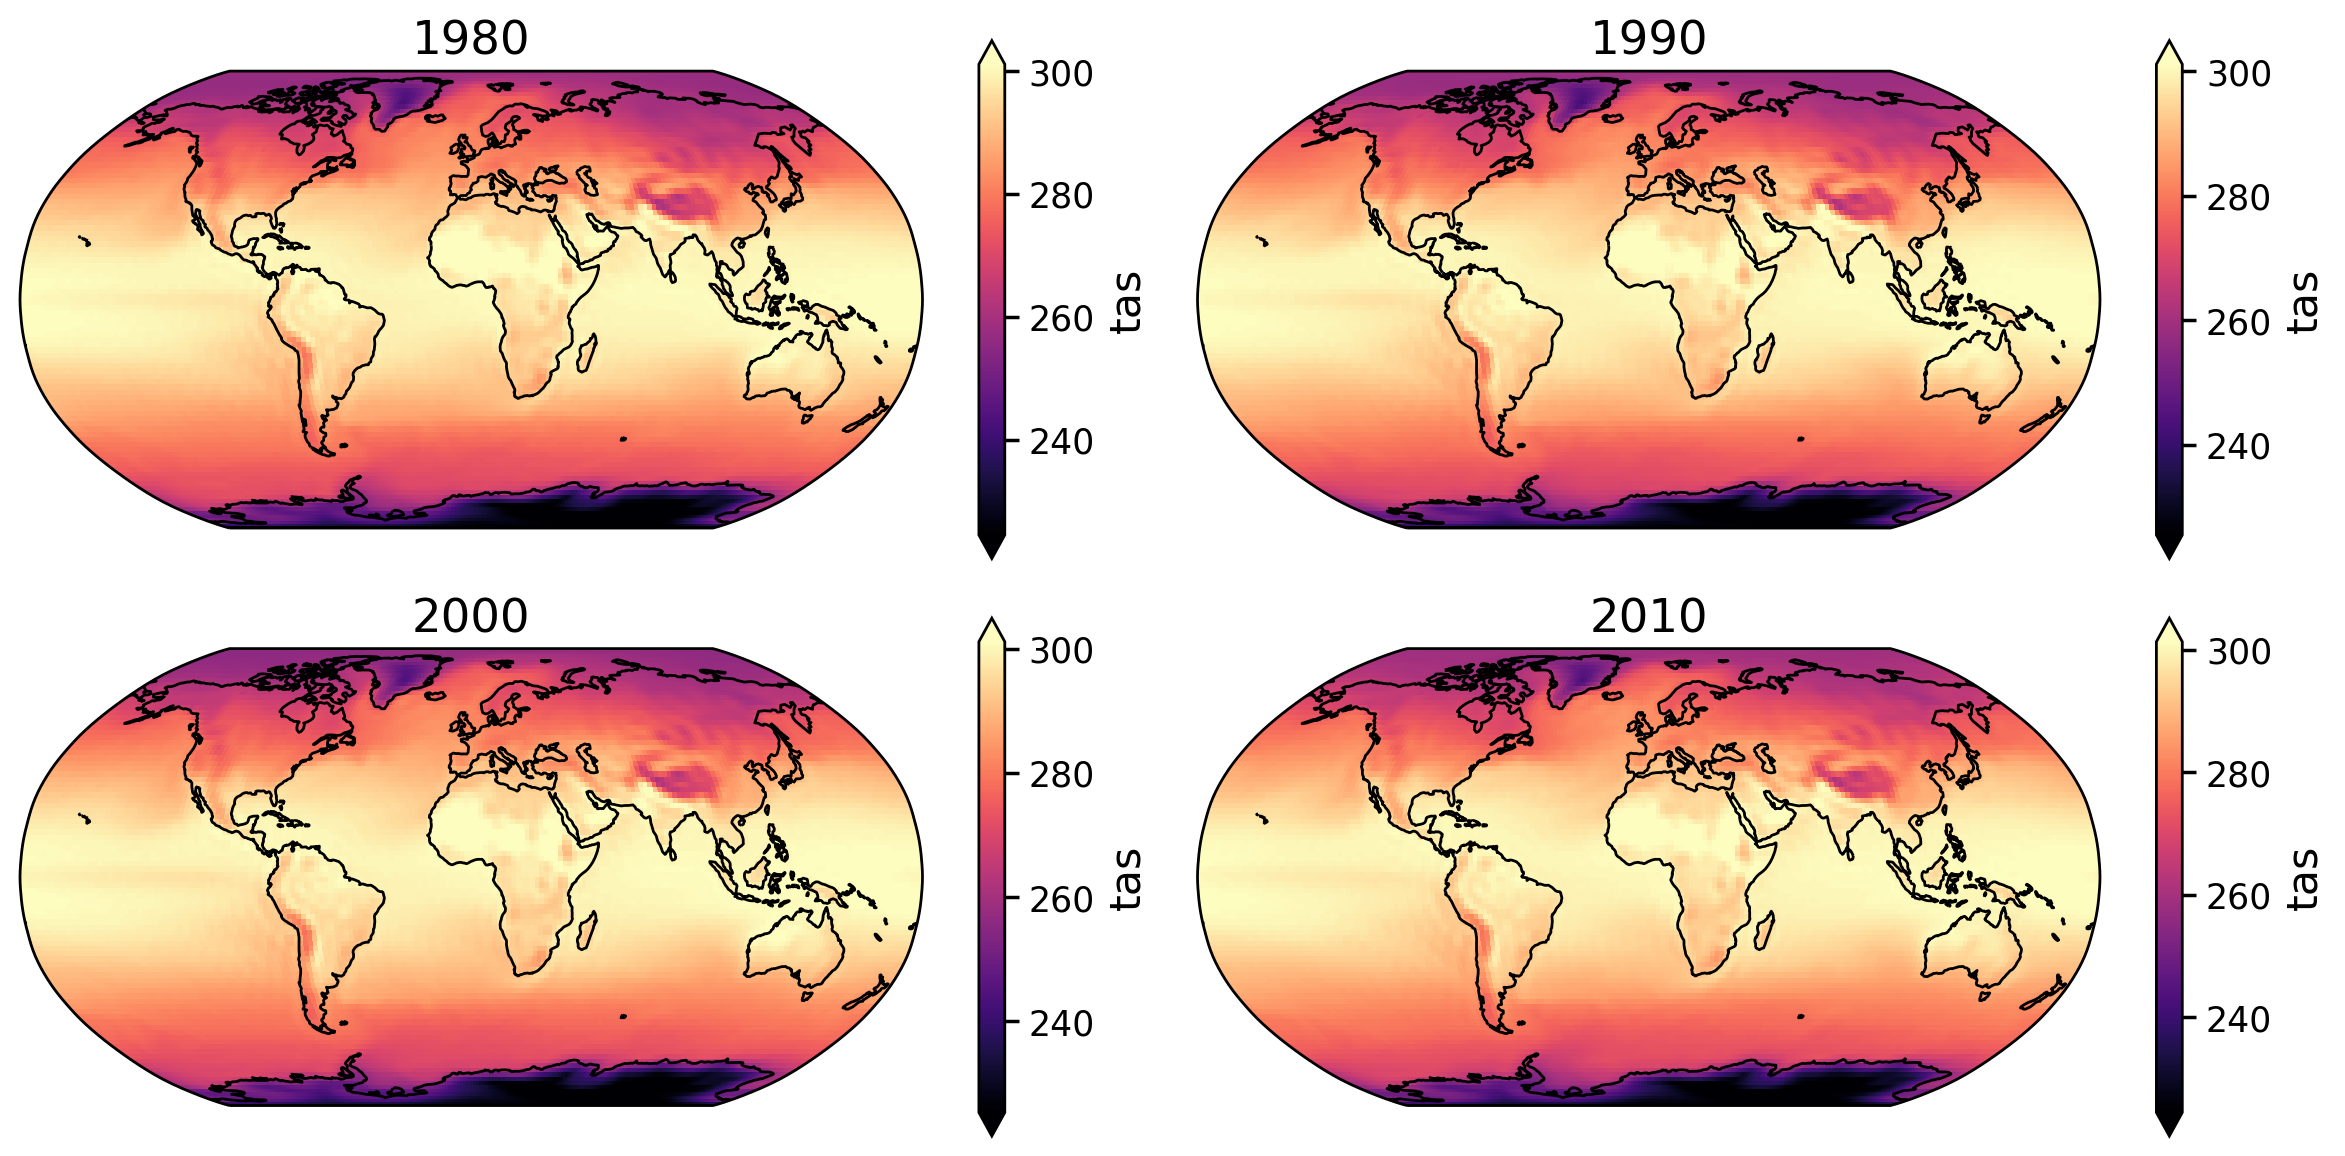

In [8]:
fig, ([ax_1980, ax_1990], [ax_2000, ax_2010]) = plt.subplots(
    ncols=2, nrows=2, figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)

    
# plot a timestep for 2023
tas_1980 = tas_historical.sel(time=slice("1980-01-01", "1980-12-31")).mean(dim="time").squeeze()
tas_1980.plot(
    ax=ax_1980,
    transform=ccrs.PlateCarree(),
    cmap="magma",
    robust=True,
)
ax_1980.coastlines()
ax_1980.set_title("1980")

# repeat for 1990
tas_1990 = tas_historical.sel(time=slice("1990-01-01", "1990-12-31")).mean(dim="time").squeeze()
tas_1990.plot(
    ax=ax_1990,
    transform=ccrs.PlateCarree(),
    cmap="magma",
    robust=True,
)
ax_1990.coastlines()
ax_1990.set_title("1990")

# repeat for 2000
tas_2000 = tas_historical.sel(time=slice("2000-01-01", "2000-12-31")).mean(dim="time").squeeze()
tas_2000.plot(
    ax=ax_2000,
    transform=ccrs.PlateCarree(),
    cmap="magma",
    robust=True,
)
ax_2000.coastlines()
ax_2000.set_title("2000")


tas_2010 = tas_historical.sel(time=slice("2010-01-01", "2010-12-31")).mean(dim="time").squeeze()
tas_2010.plot(
    ax=ax_2010,
    transform=ccrs.PlateCarree(),
    cmap="magma",
    robust=True,
)
ax_2010.coastlines()
ax_2010.set_title("2010")

### Q2: Mask out the ocean, and plot the global mean temperature (yearly average) as a function of time for the past 50 years. Optionally you can also add soil moisture and/or precipitation.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
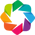

:HoloMap   [year]
   :Overlay
      .Image.I     :Image   [y,x]   (tas)
      .Coastline.I :Feature   [Longitude,Latitude]

In [8]:
holoviews.extension("bokeh")
tas_yearly_50 = tas_historical.sel(time=slice("1961-01-01", "2010-12-31")).groupby("time.year").mean()
tas_plot = gvDataset(
    tas_yearly_50.isel(year=slice(0, 2))
)  # first 5 time steps
tas_yearly_50
images = tas_plot.to(
    gvImage, ["y", "x"], ["tas"], "year"
)
images.opts(
    cmap="coolwarm",
    colorbar=True,
    width=600,
    height=400,
    projection=ccrs.Robinson(),
    clabel="Temperature",

) * gf.coastline


### Detect heat days for specific date (global) 

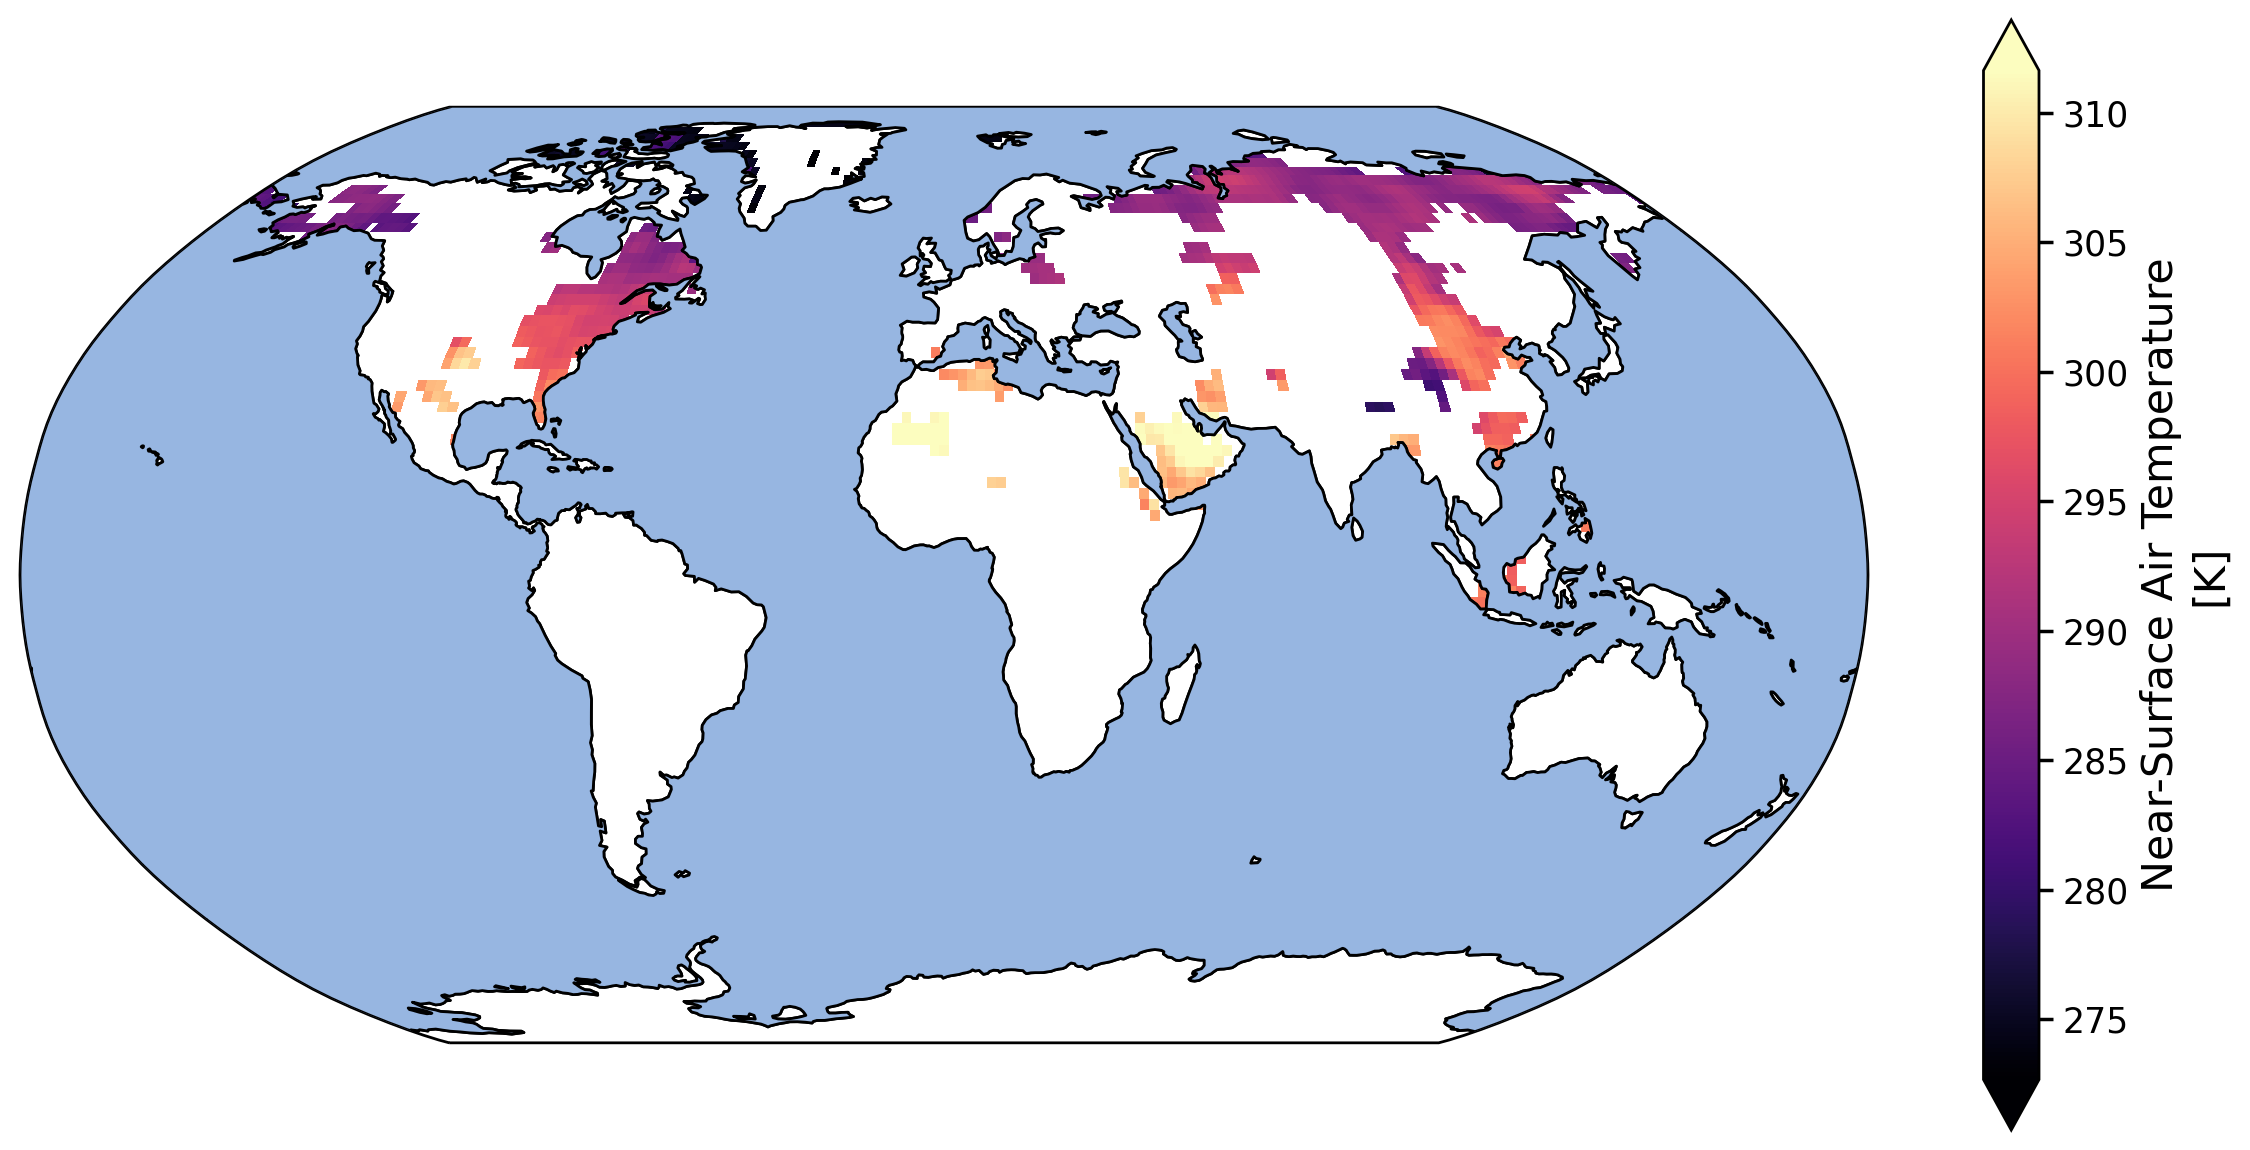

In [9]:
def plot_global_temperature_map(ds):
    fig, ax_present = plt.subplots(
            figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
        )
    ds.plot(ax=ax_present, transform=ccrs.PlateCarree(), cmap="magma", robust=True)
    ax_present.coastlines()
    ax_present.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='k')
    ax_present.set_title("")
    plt.show()

w_day = 10
tas_selected = tas_historical.sel(time=slice("2000-01-01", "2001-12-31")).squeeze()
tas_daily_mean = tas_selected.resample(time='D').mean(dim='time')
tas_rolling_P95 = tas_daily_mean.rolling(time=w_day, center=True).mean().chunk(time=-1).quantile(.95, dim='time')
tas_grtr_P95 = tas_daily_mean>tas_rolling_P95 # Create Boolean mask
tas_heat_cells = tas_daily_mean.where(tas_grtr_P95).sel(time="2000-07-03").squeeze()

plot_global_temperature_map(tas_heat_cells)

### Q7: Heat wave detection in region

In [27]:
def compute_tasAndP95mask(tas_historical, year_range):
    """
    computes global temperatures and P95 masks
    """
    
    tas_grtr_P95_all = []
    tas_daily_mean_all = []
    for year in year_range:
        year_start = f"{year}-01-01"
        year_end = f"{year}-12-31"

        # Compute daily mean from
        tas_selected = tas_historical.sel(time=slice(year_start, year_end)).squeeze()
        tas_daily_mean_yrly = tas_selected.resample(time='D').mean(dim='time')
        tas_rolling_P95_yrly = tas_daily_mean_yrly.rolling(time=w_day, center=True).mean().chunk(time=-1).quantile(.95, dim='time')
        tas_grtr_P95_yrly = tas_daily_mean_yrly>tas_rolling_P95_yrly
        tas_grtr_P95_all.append(tas_grtr_P95_yrly)
        tas_daily_mean_all.append(tas_daily_mean_yrly)

    return tas_daily_mean_all, tas_grtr_P95_all
# Given a day, this function computes if the region of interest experienced heatwave

def get_distance_km(lat1, lon1, lat2, lon2):
    """Calculate distance in kilometers between two lat-long points.
    """
    # Create two points
    A = geopy.Point(lat1, lon1)
    B = geopy.Point(lat2, lon2)

    # Calculate the distance between the two points
    dist_km = geopy.distance.distance(A, B).km
    
    return dist_km 


def get_weights(ds):
    """For a rectangular grid the cosine of the latitude 
    is proportional to the grid cell area.
    """
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
 
    return weights


def get_max_cell_area_kmsqr(ds):
    """Calculate the difference in square km between two
    neightboring cells that have a weight of 1 (largest).
    """
    # Get geo-distance between random neighboring points on 
    # lat=-0.9326 which is axis of largest cells
    lat1 = -0.9326
    lon1 = 360.0
    lat2 = lat1
    lon2 = 1.875

    #weights.sel(y=lat1, x=lon1, method="nearest") 
    #weights.sel(y=-lat2, x=lon2, method="nearest")

    max_cell_length = get_distance_km(lat1, lon1, lat2, lon2)
    
    # area as sqared length
    max_cell_area = max_cell_length**2
    
    return max_cell_area


def get_area_of_cell_kmsqr(ds, cell_lat, cell_lon):
    """Since weights have values from 0 to 1, we can
    get the cell km^2-area by weighting with max 
    cell area.
    """
    area = get_weights(ds)*get_max_cell_area_kmsqr(ds)
    area.name = "area"
 
    cell_area = area.sel(y=cell_lat, x=cell_lon, method="nearest")

    return cell_area


def heatwave_over_region(tas_region, 
                         P95_mask_region, 
                         E, X, 
                         start_date=(2010, 7, 15), 
                         plotting=True,
                         mask_ocean=False,
                         verbose=True,
                         ret = False
                        ):
    """
    tas_region: daily mean temperature of the region of interest for the year "year_ofinterest"
    P95_mask_region: mask of the region of interest for the year "year_ofinterest"
    E: minimum area (km^2) with tas>P95 for heatwave
    X: minmum number of days over which tas>P95
    """
    
    lat, lon, time = P95_mask_region.indexes.values()
    # year, month, day = start_date
    end_date = start_date + timedelta(days = X-1)
    if (end_date.year>start_date.year):
        print("Can't detect heatwaves for days that span more than a year")
        return 0
    # print((end_date.strftime('%Y-%m-%d')))
    tas_X_days = P95_mask_region.sel(time=slice(start_date.strftime('%Y-%m-%d'),end_date.strftime('%Y-%m-%d')))
    tas_X_days_numpy = np.nan_to_num(tas_X_days.as_numpy())
    ht_array, num_ht = label(np.prod(tas_X_days_numpy, axis=0))
    # print(ht_array)
    for ii in range(num_ht):
        coords = np.argwhere(ht_array==(ii+1))        
        cell_lats = lat[coords[:, 0]]
        cell_lons = lon[coords[:, 1]]
        
        # dst = tas_daily_mean.sel(time="1980").squeeze()  
        dst = tas_daily_mean.sel(time=str(year_ofinterest)).squeeze() 
        # 1980, 2000, start_date.strftime('%Y-%m-%d')
        area = 0
        for cell_lon in cell_lons:
            for cell_lat in cell_lats:
                area += get_area_of_cell_kmsqr(dst,
                                               cell_lat=cell_lat, 
                                               cell_lon=cell_lon)
        
        #print(area)
        if (area<E):
            for c_i in coords[:, 0]:
                for c_j in coords[:, 1]:
                    ht_array[c_i, c_j] = 0

    if verbose:               
        print(f"Number of heat waves recorded on the date {start_date}: {len(np.unique(ht_array))-1}")
    # uncomment if want to see output temperature array
    # print(np.nan_to_num(tas_region.sel(time=start_date.strftime('%Y-%m-%d')).squeeze().where(ht_array).as_numpy()))
    if plotting:
        fig, ax_present = plt.subplots(figsize=[8, 4], subplot_kw={"projection": ccrs.Robinson()})
        tas_region.sel(time=start_date.strftime('%Y-%m-%d')).squeeze().where(ht_array).plot(ax=ax_present, transform=ccrs.PlateCarree(), 
                                                                                            cmap="magma", robust=True)
        ax_present.coastlines()
        if mask_ocean:
            ax_present.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='k')
        ax_present.set_title(f"Heatwaves on {start_date.strftime('%Y-%m-%d')}")
        plt.show()
    if ret:
        return len(np.unique(ht_array))-1

### Plotting heat cells over X days in region of interest

In [24]:
# - we count total number of cells in a given region for a number of consecutive days (count_cells_all_days)
# - we count the number of heat cells (i.e. cells that show temperature above the 95% quantile (count_heat_cells_all_days)
# - the ratio between heat cells and total number of cells (count_heat_cells_all_days / count_cells_all_days) is compared to a threshold value
# - if the ratio is higher than the threshold, a heat wave is detected. Otherwise not.

def count_cells(ds):
    """Counts the number of cells in a data set"""
    x = ds.x.shape[0]
    y = ds.y.shape[0]
    return x * y


def count_true_cells_in_mask(ds_mask):
    """Counts the number of heat cells in a data set"""
    return ds_mask.sum().to_numpy()


def get_heat_waves_from_date(tas_daily_mean_masked,
                             tas_grtr_P95_ME,
                             start_date, 
                             nb_days=5, 
                             threshold=0.25,
                             verbose=False,
                             plotting=False,
                           ):
    """
    Based on a threshold, calculate the percentage of heat days over a 
    given number of days (e.g. 5 days) given a starting data.
    
    tas_daily_mean_masked: masked daily mean values
    tas_grtr_P95_ME: mask
    start_date: date at which to start looking for heatwaves
    nb_days: number of days necessary to count as a heatwave
    threshold: detection threshold for heatwave
    verbose: print results (boolean)
    plotting: plot results (boolean)
    """

    # year, month, day = start_date
    # start_date = datetime.date(year, month, day)

    count_cells_all_days = 0
    count_heat_cells_all_days = 0

    for day_i in range(nb_days):
        t = datetime.timedelta(days=-int((nb_days-1)/2)) + start_date + datetime.timedelta(days=day_i)
        t = t.strftime('%Y-%m-%d')

        tas_daily_mean_day = tas_daily_mean_masked.sel(time=t).squeeze()
        tas_grtr_P95_day = tas_grtr_P95_ME.sel(time=t).squeeze()

        count_cells_all_days += count_cells(tas_grtr_P95_day)
        count_heat_cells_all_days += count_true_cells_in_mask(tas_grtr_P95_day)

        if plotting is True:
            fig, ax_present = plt.subplots(figsize=[8, 4], 
                                           subplot_kw={"projection": ccrs.Robinson()})
            tas_daily_mean_day.plot(ax=ax_present, 
                                    transform=ccrs.PlateCarree(), 
                                    cmap="magma", robust=True)
            ax_present.coastlines()
            ax_present.add_feature(cart.feature.OCEAN, zorder=100, edgecolor='k')
            ax_present.set_title("Day " + str(day_i-int((nb_days-1)/2)) + " (" + t + ")")# - int((nb_days-1)/2)), t)
            plt.show()

    # Calculate percentage of heat cells over given number of days
    heat_cell_perc = count_heat_cells_all_days / count_cells_all_days
    heat_wave_detect = heat_cell_perc > threshold
    
    if verbose is True:
        print("Date: ", start_date.strftime('%Y-%m-%d'), " to ", t)
        print("Number of days: ", nb_days)
        print("Heat Wave Detected:", heat_wave_detect)
        print("Threshold of: ", str(threshold*100) + "%")
        print("Heat Cell Perc", str(np.round(heat_cell_perc, 2)*100) + "%")
        print("Nb Heat Cells", count_heat_cells_all_days)
        print("Nb Cells", count_cells_all_days)
        
    return heat_wave_detect, heat_cell_perc
        


### Main: Heatwave Detection

Number of heat waves recorded on the date 2010-07-15: 2


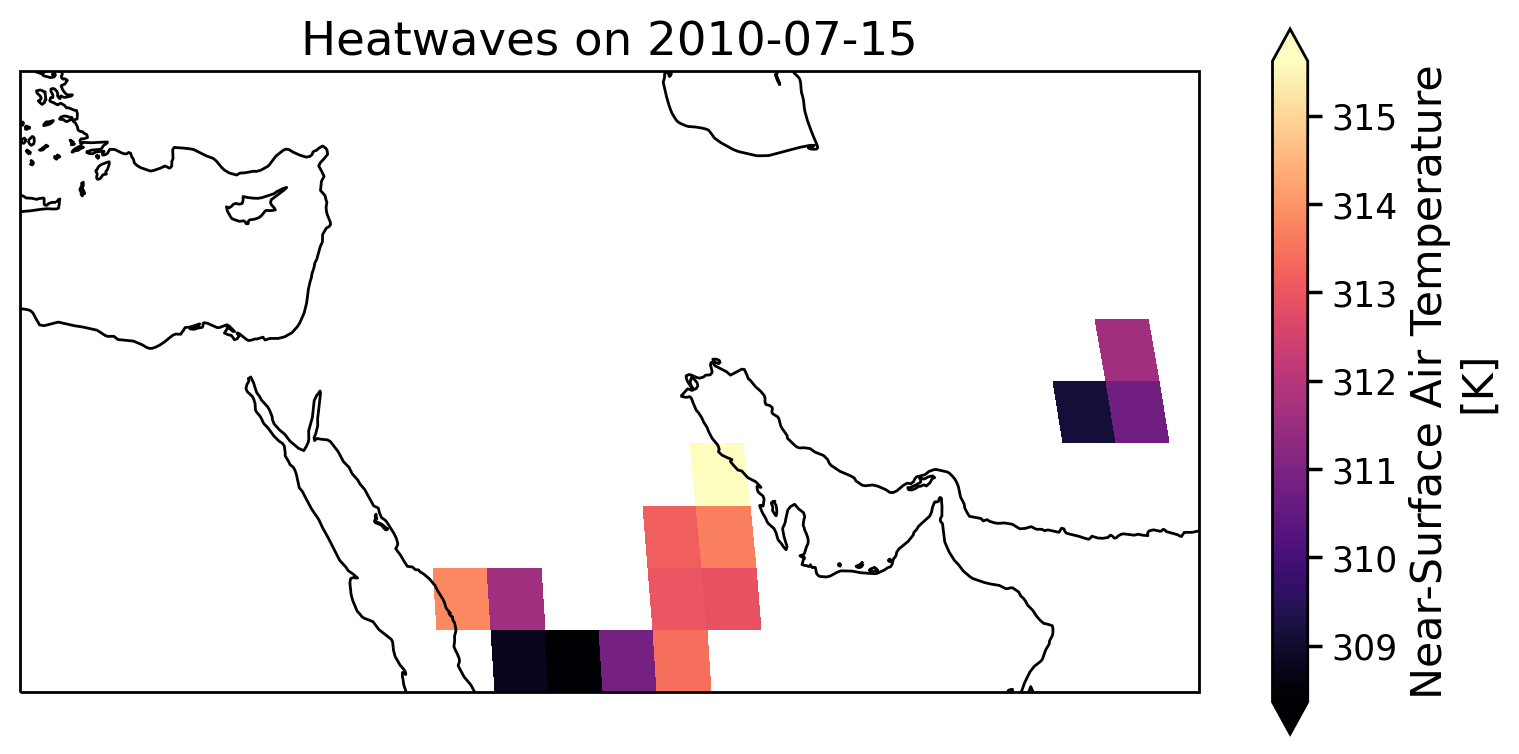

In [20]:
w_day = 10
E = 200*200 # km^2, minimum area over which tas>P95 for heatwave to exist
X = 7 # days, minimum number of days for which tas(area)>P95 for heatwave to exist
year_range = list(np.arange(1979, 2015))
year_ofinterest = 2010
start_date = date(year_ofinterest, 7, 15)

tas_daily_mean_all, tas_grtr_P95_all = compute_tasAndP95mask(tas_historical, year_range)

tas_daily_mean = tas_daily_mean_all[year_range.index(year_ofinterest)]
tas_grtr_P95 = tas_grtr_P95_all[year_range.index(year_ofinterest)]


# We have chosen Middle East (ME) as our region of interest (where we want to detect heatwaves). 
# ME is approximately bounded within  [25°E to 65°E] and  [20°N to 40°N]

# Slice of lon and lat coordinates for middle east
lon_slice = slice(25, 65)  # Longitude Range: Approximately 25°E to 65°E
lat_slice = slice(20, 40)   # Latitude Range: Approximately 20°N to 40°N
tas_daily_mean_ME = tas_daily_mean.sel(x=lon_slice, y=lat_slice)
tas_grtr_P95_ME = tas_grtr_P95.sel(x=lon_slice, y=lat_slice)
tas_daily_mean_grtr_P95_ME = tas_daily_mean_ME.where(tas_grtr_P95_ME)

heatwave_over_region(tas_daily_mean_ME, 
                     tas_grtr_P95_ME, 
                     E, 
                     X, 
                     start_date)

#### Detect heatwaves in fixed region


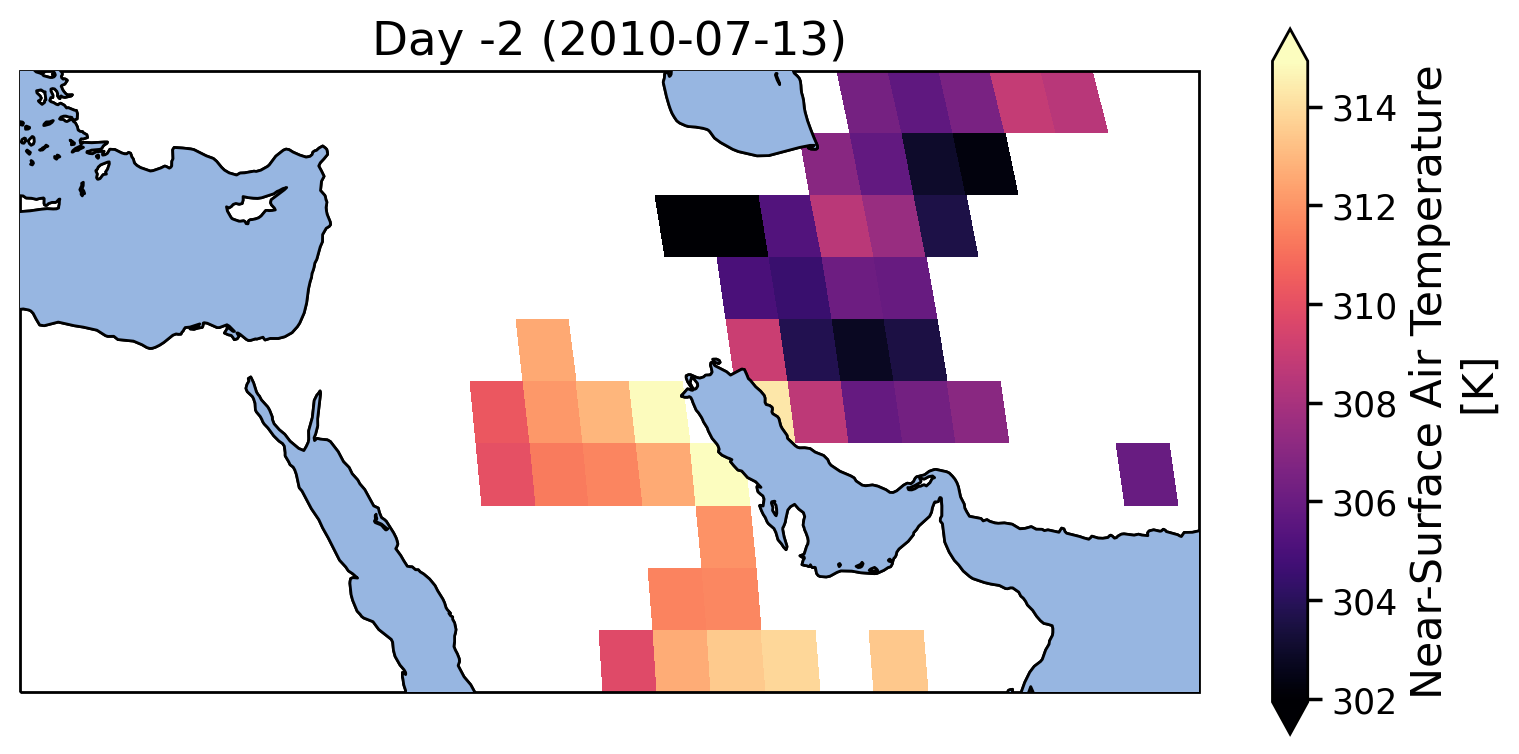

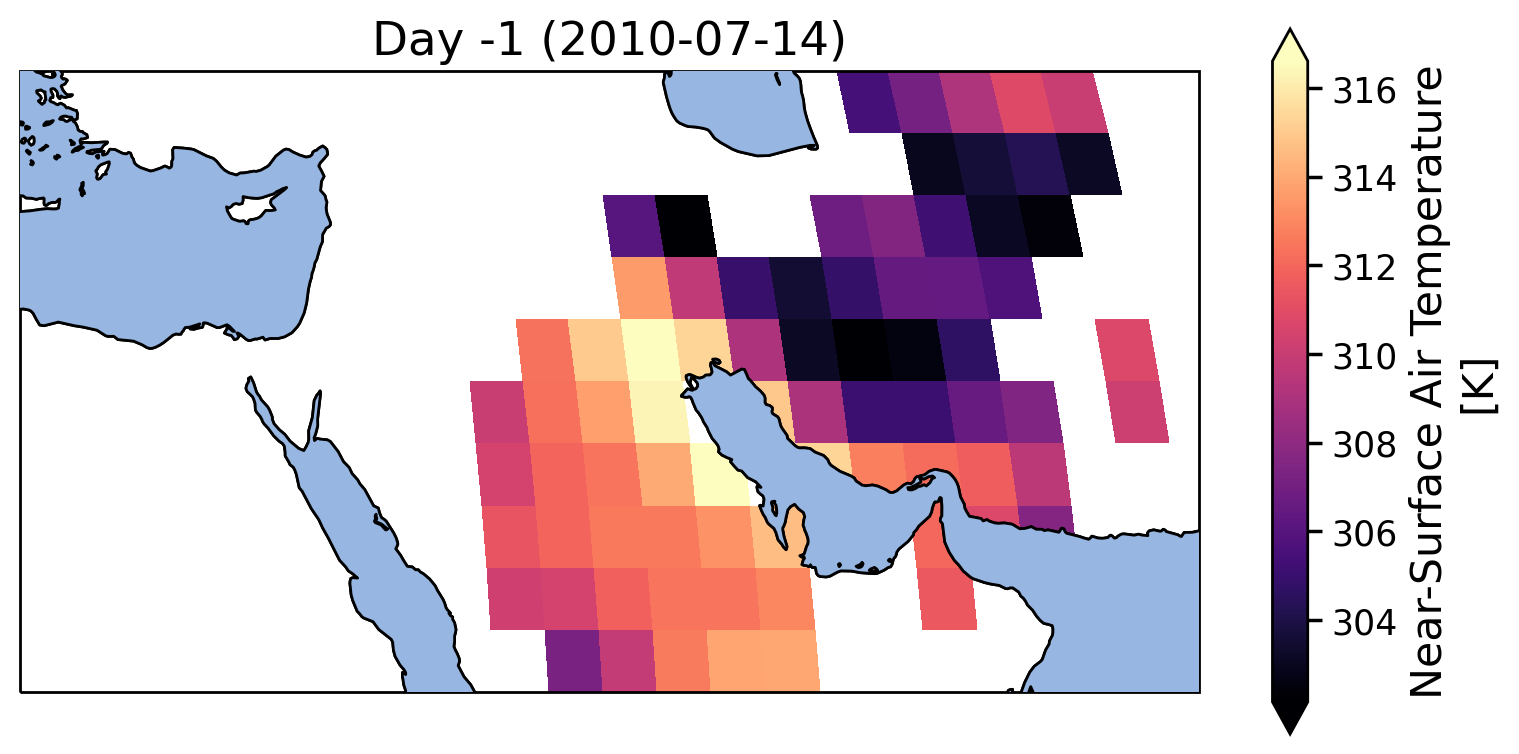

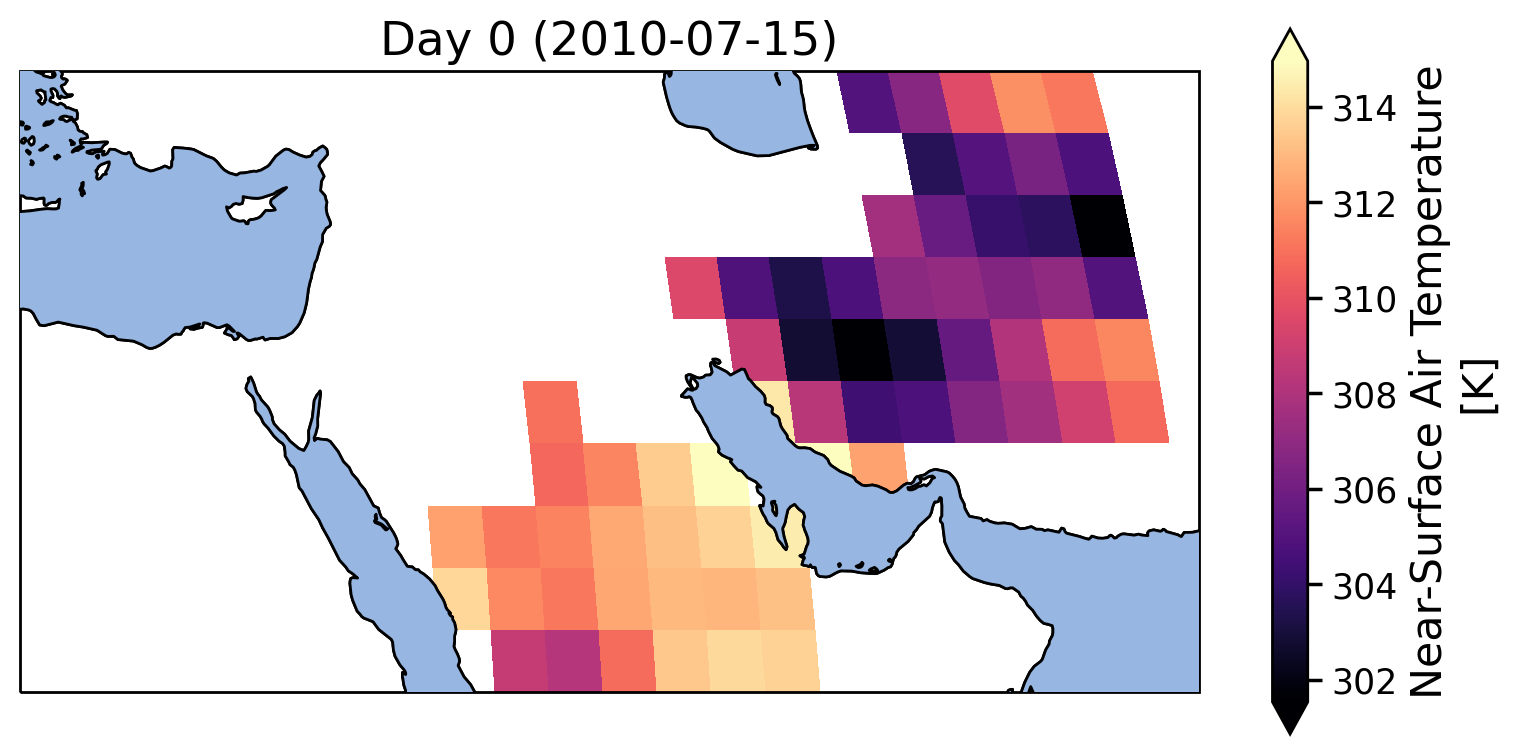

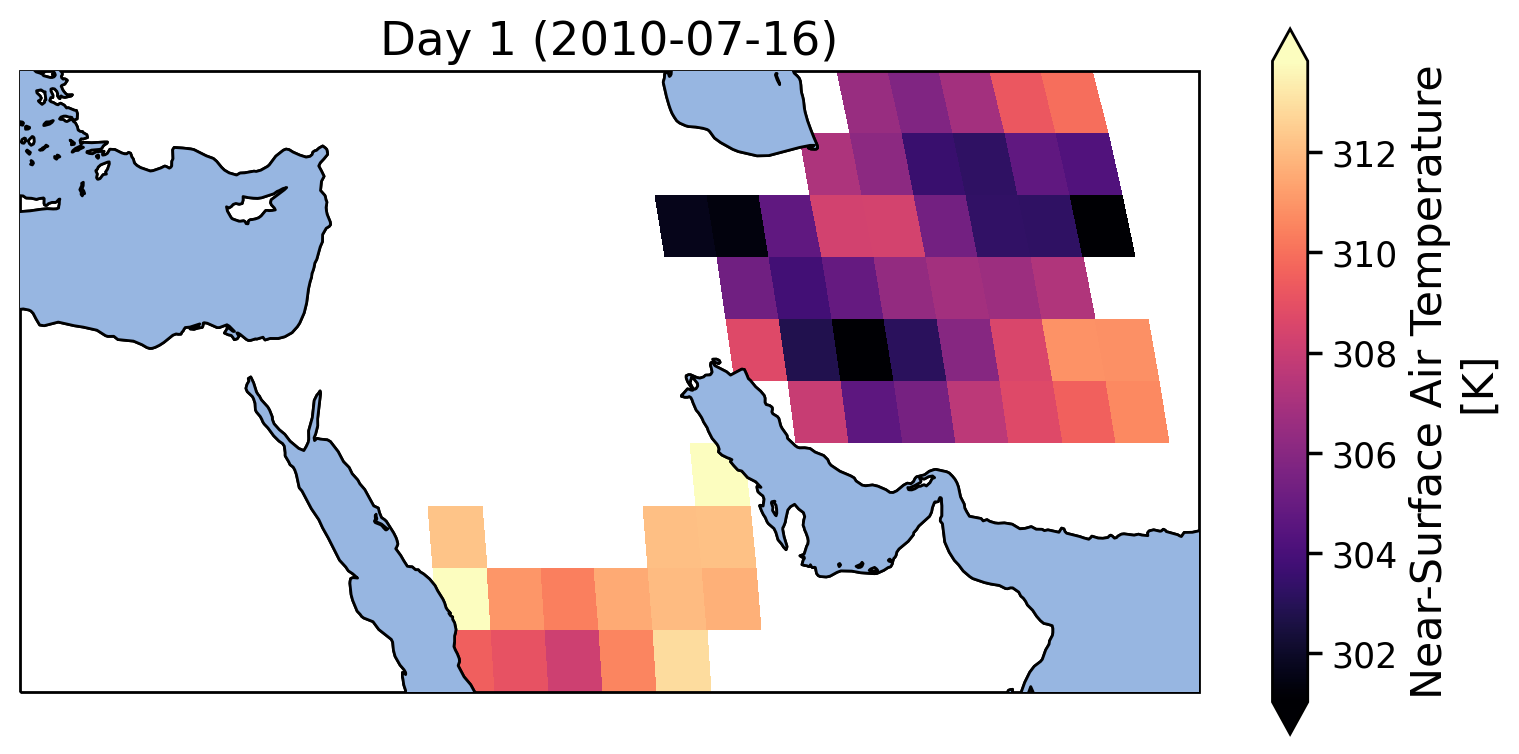

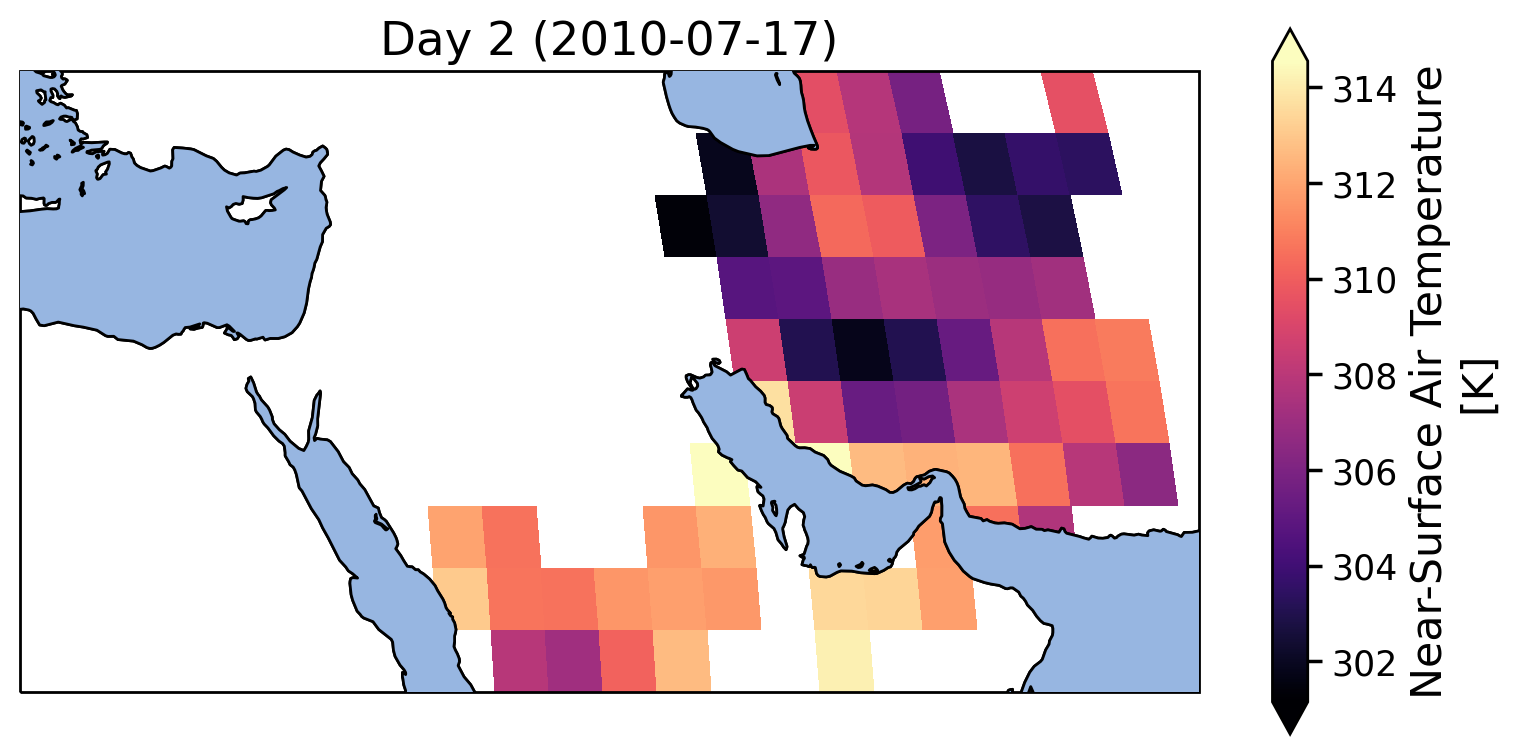

Date:  2010-07-15  to  2010-07-17
Number of days:  5
Heat Wave Detected: True
Threshold of:  25.0%
Heat Cell Perc 30.0%
Nb Heat Cells 320
Nb Cells 1050


(True, 0.3047619047619048)

In [22]:
get_heat_waves_from_date(tas_daily_mean_grtr_P95_ME,
                                   tas_grtr_P95_ME,
                                   start_date, 
                                   nb_days=5, 
                                   threshold=0.25,
                                   verbose=True,
                                   plotting=True,
                                   )

Number of heat waves recorded on the date 1979-07-01: 2


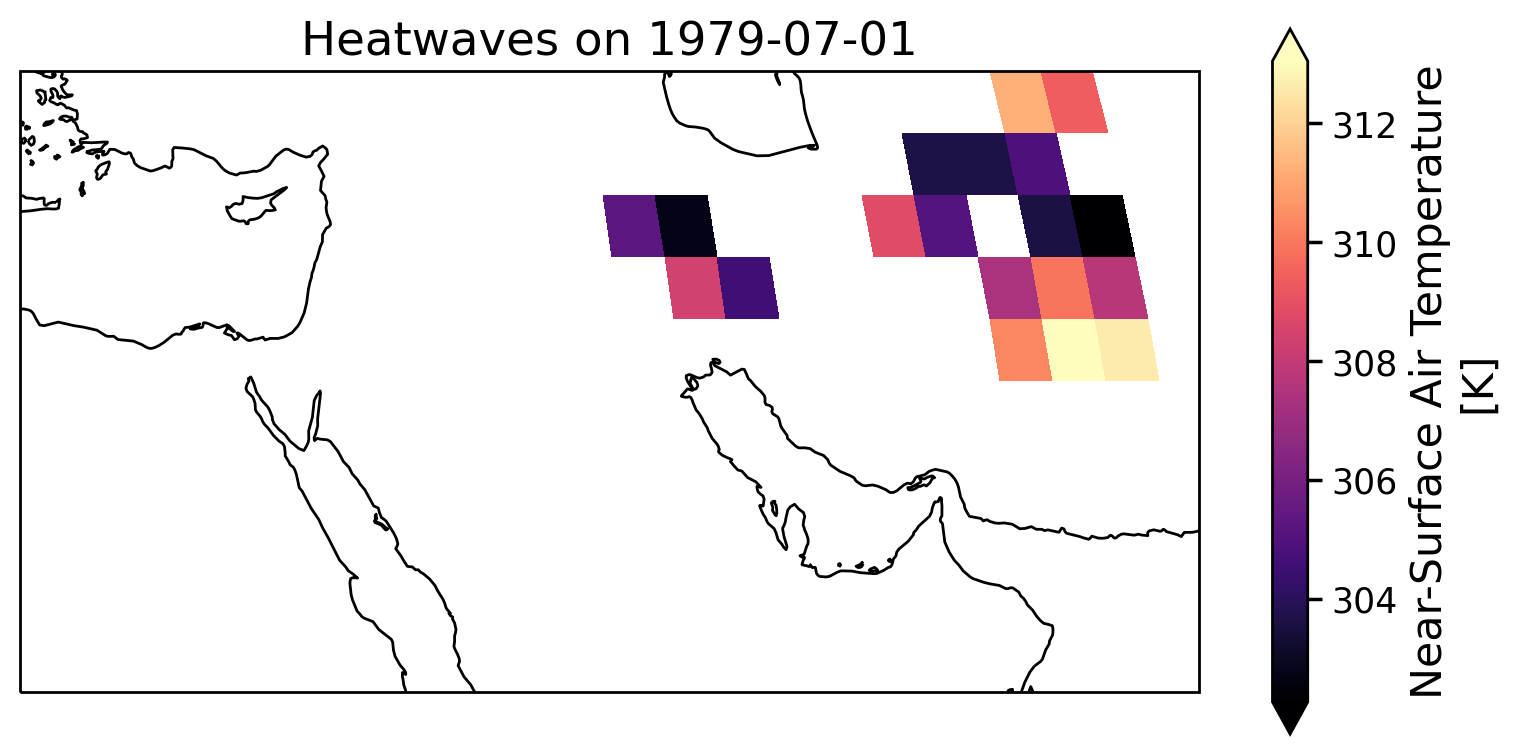

Number of heat waves recorded on the date 1979-07-08: 3


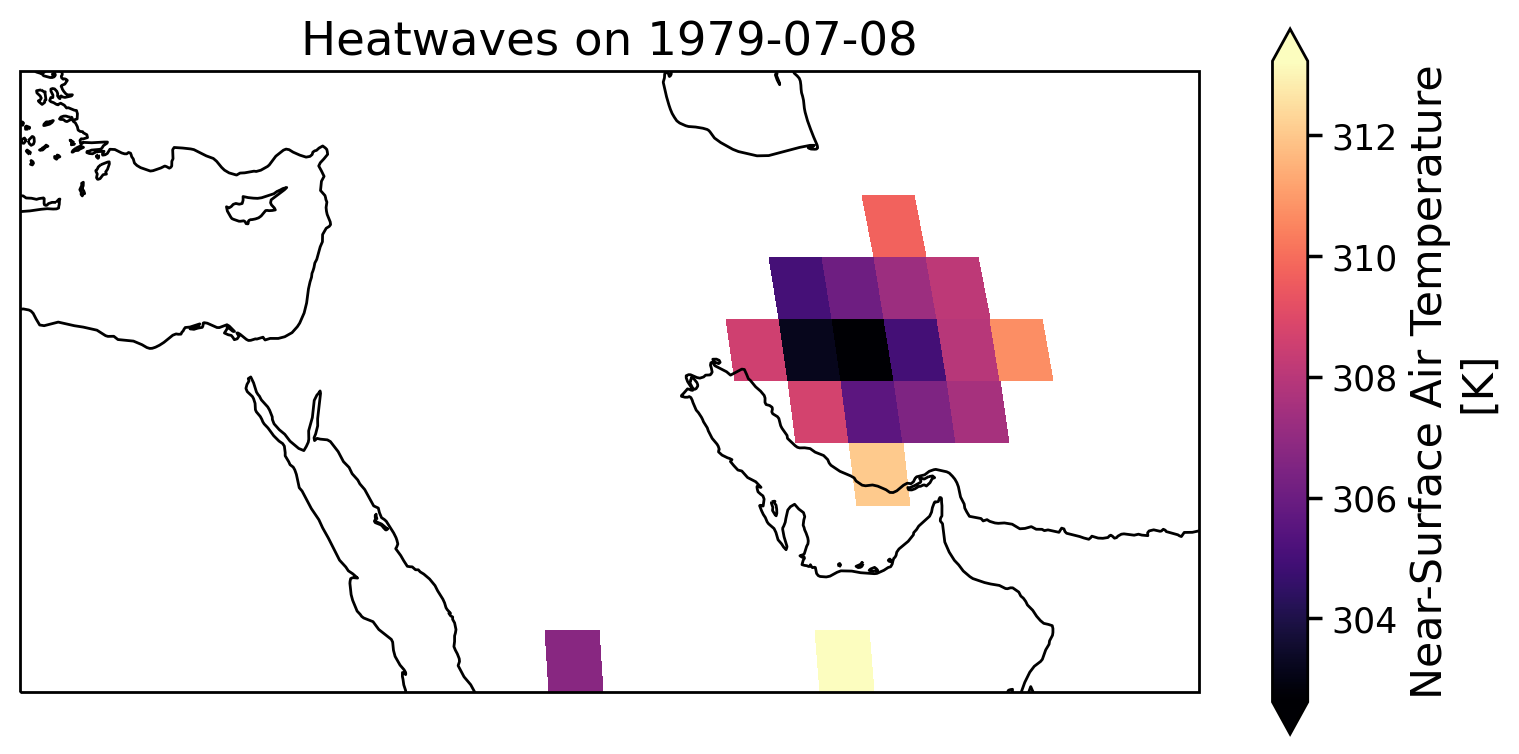

Number of heat waves recorded on the date 1979-07-15: 4


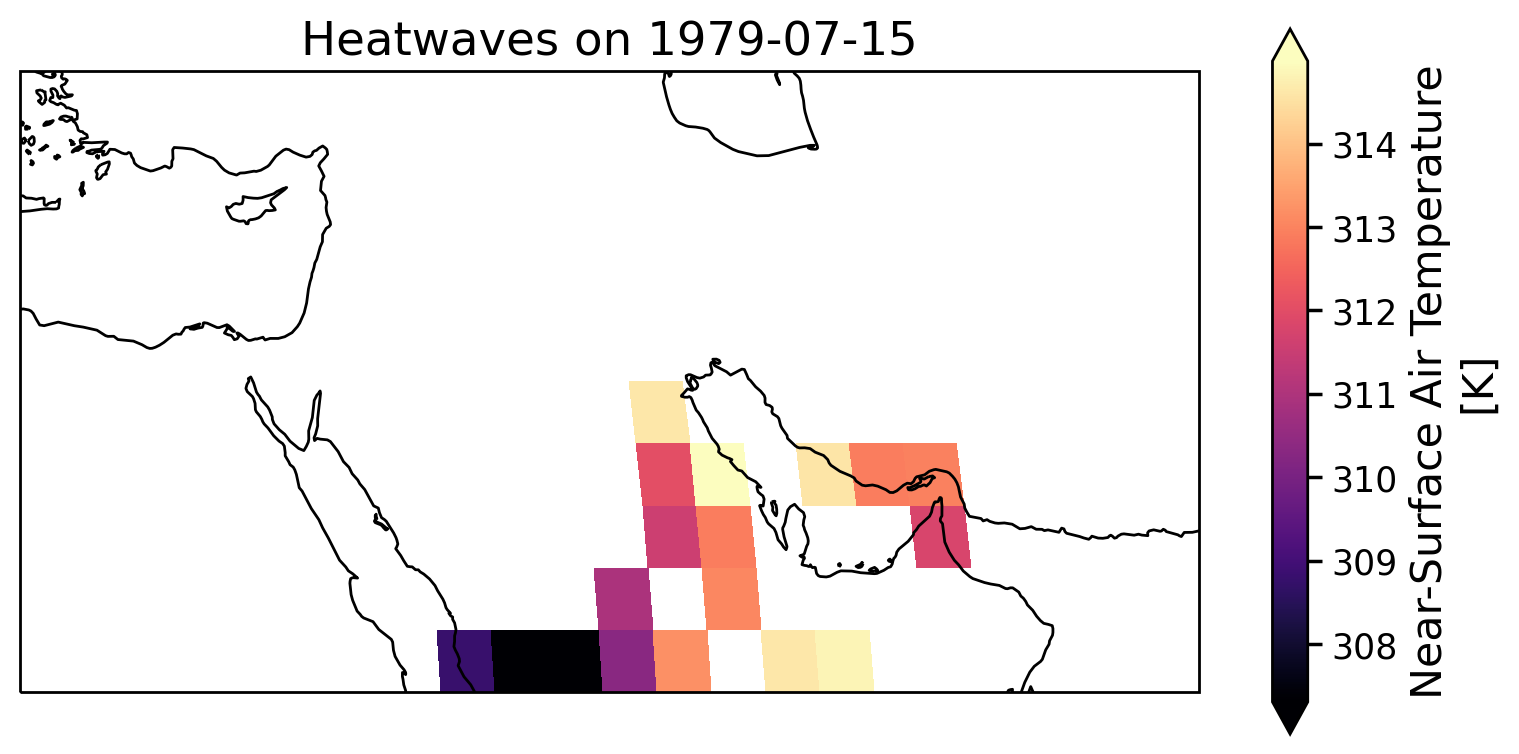

Number of heat waves recorded on the date 1979-07-22: 3


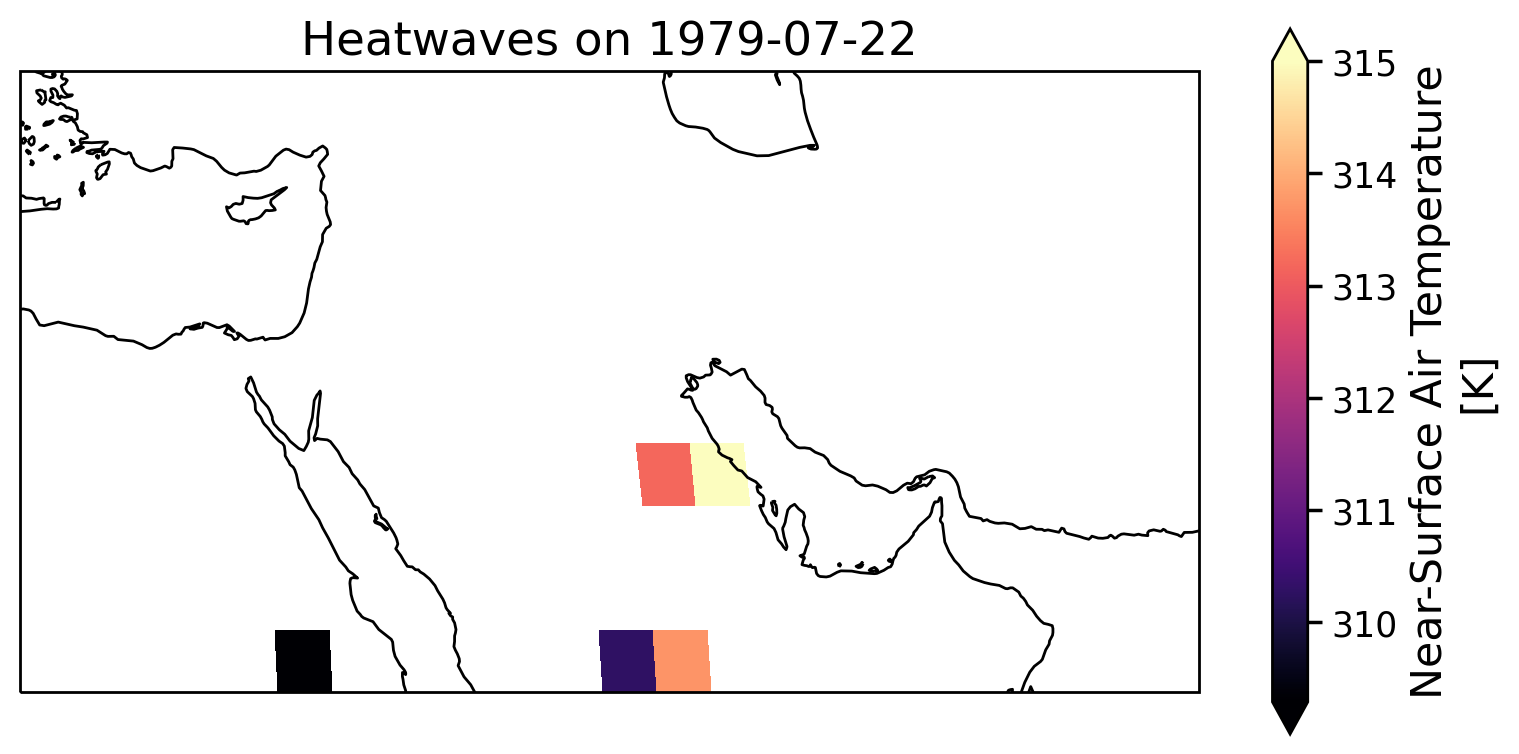

Number of heat waves recorded on the date 1979-07-29: 1


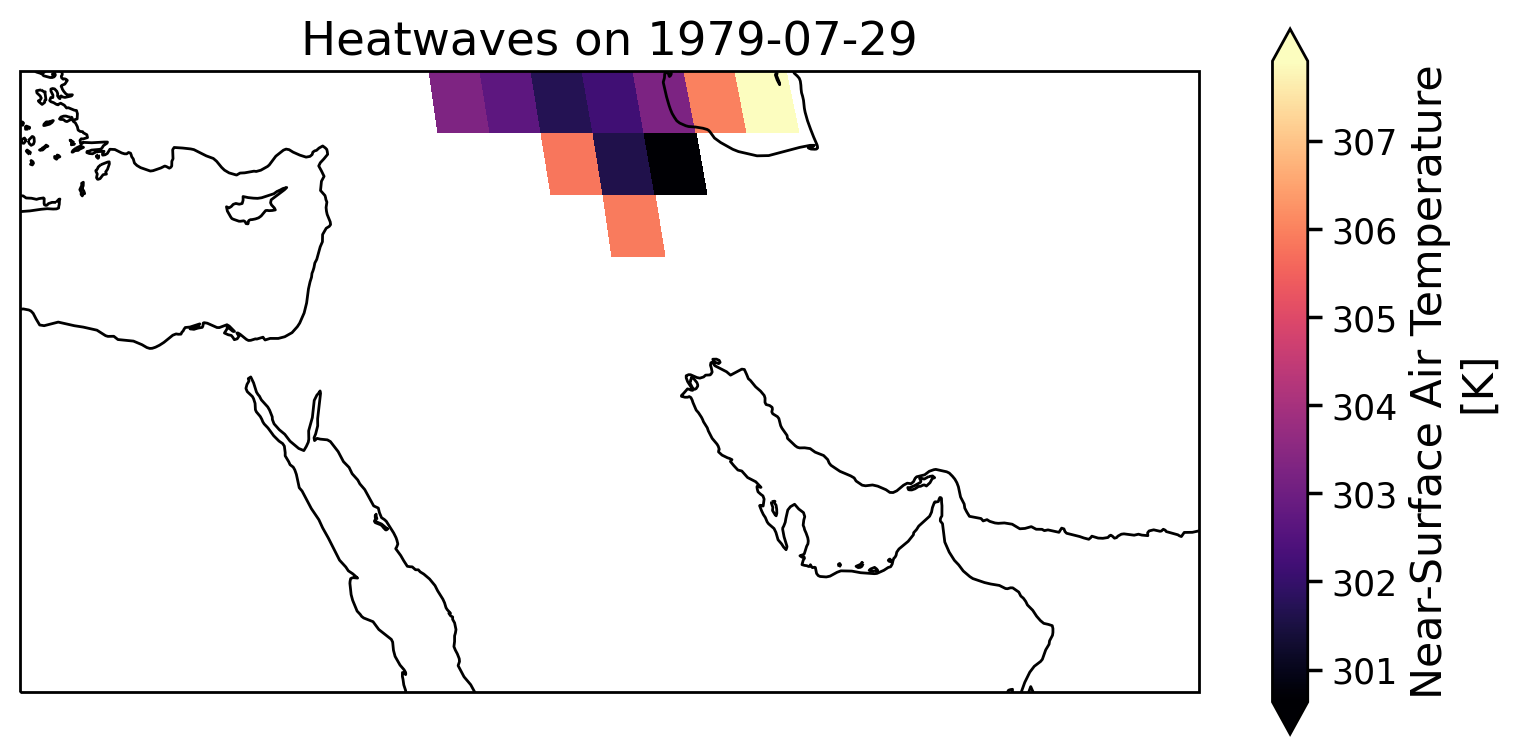

Number of heat waves recorded on the date 1979-08-05: 0


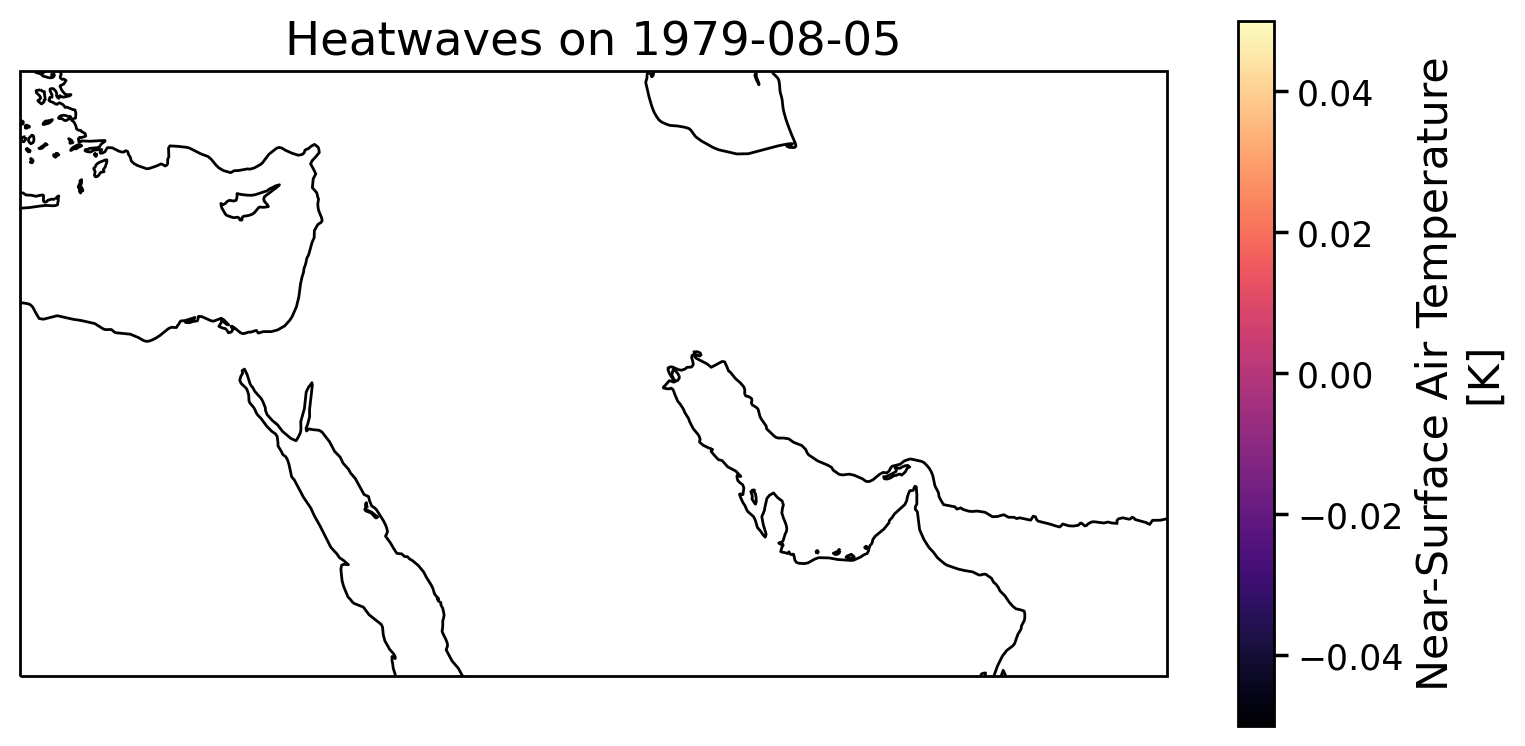

Number of heat waves recorded on the date 1979-08-12: 1


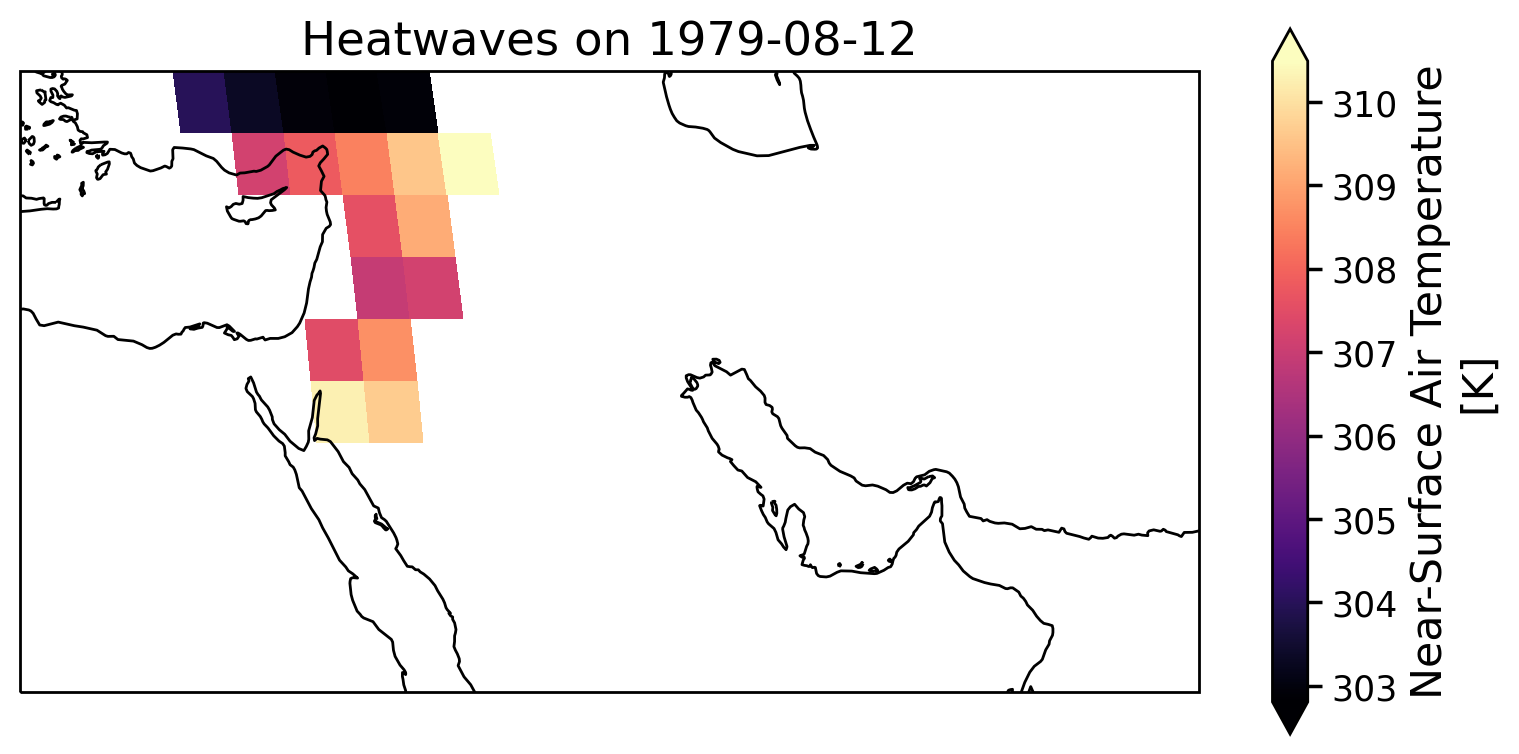

Number of heat waves recorded on the date 1979-08-19: 2


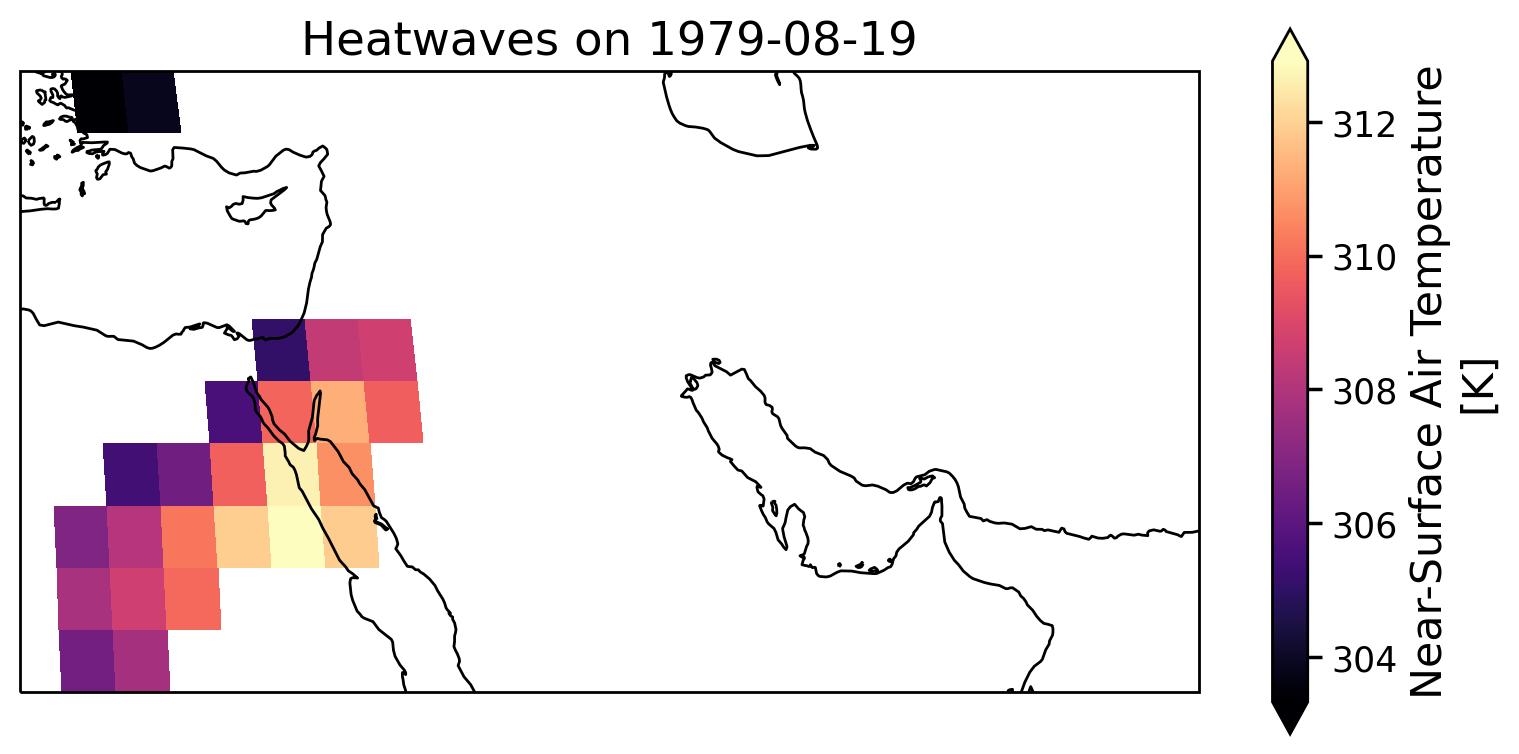

Number of heat waves recorded on the date 1979-08-26: 5


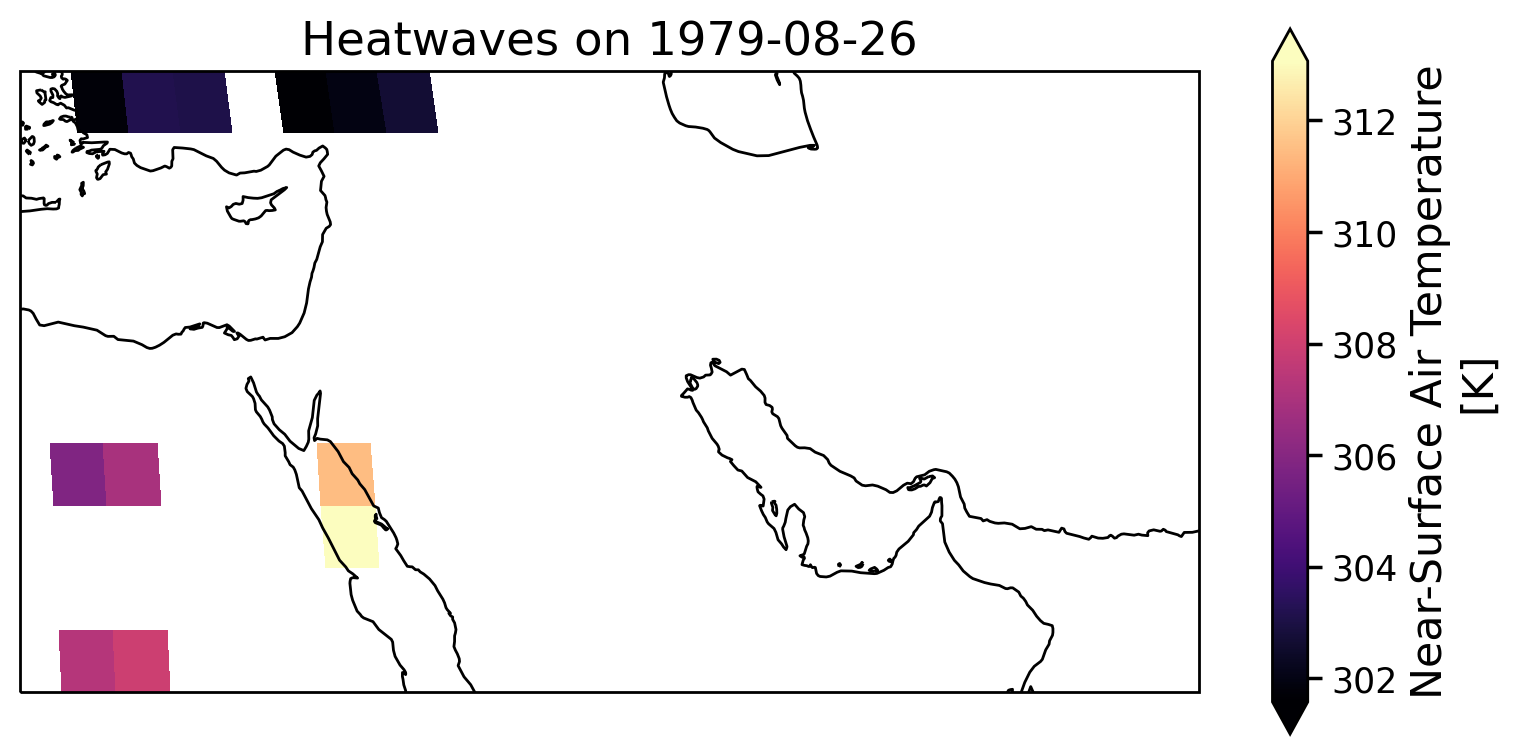

Total number of heatwaves in the year 1979 are 21


In [35]:
def annual_mean_heatwave(year_range,
                         E, X,
                         tas_daily_mean_all, 
                         tas_grtr_P95_all, 
                         lon_slice, 
                         lat_slice):
    n_hw=[]
    for year in year_range:
        tas_daily_mean = tas_daily_mean_all[year_range.index(year)]
        tas_grtr_P95 = tas_grtr_P95_all[year_range.index(year)]
        tas_daily_mean_regional = tas_daily_mean.sel(x=lon_slice, y=lat_slice)
        tas_grtr_P95_regional = tas_grtr_P95.sel(x=lon_slice, y=lat_slice)
        # tas_daily_mean_grtr_P95_regional = tas_daily_mean_regional.where(tas_grtr_P95_ME)

        sdate = date(year,7,1)   # start date
        edate = date(year,8,31)   # end date
        dates = [sdate+timedelta(days=x) for x in range(0,(edate-sdate).days, X)]
        n_total=0
        for start_date in dates:
            n = heatwave_over_region(tas_daily_mean_regional, tas_grtr_P95_regional, E, X, start_date, 
                                     plotting=True,mask_ocean=False, verbose = True, ret=True)
            n_total = n_total+n
        print(f"Total number of heatwaves in the year {year} are {n_total}")
        n_hw.append(n_total)
        # print(n_hw)
    return n_hw
    
    
    
# hw_over_years = annual_mean_heatwave(year_range,E, X,tas_daily_mean_all, tas_grtr_P95_all, lon_slice, lat_slice)
hw_over_years = annual_mean_heatwave([1979],E, X,tas_daily_mean_all, tas_grtr_P95_all, lon_slice, lat_slice)

In [42]:
tas_daily_mean_all[0]

<xarray.DataArray 'tas' (time: 365, y: 96, x: 192)>
dask.array<transpose, shape=(365, 96, 192), dtype=float32, chunksize=(204, 96, 192), chunktype=numpy.ndarray>
Coordinates:
    height          float64 2.0
  * y               (y) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * x               (x) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.1 358.1 358.1
    lat             (x, y) float64 -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
    member_id       <U8 'r1i1p1f1'
    dcpp_init_year  float64 nan
  * time            (time) object 1979-01-01 00:00:00 ... 1979-12-31 00:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: point
    comment:        near-surface (usually, 2 meter) air temperature
    history:        2019-09-11T14:13:17Z altered by CMOR: Treated scalar dime...
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

In [31]:
years = range(1979, 2010)
hw = [25, 18, 19, 28, 20, 23, 20, 20, 15, 16, 18, 12, 17, 14, 26, 20, 23, 15, 19, 23, 18, 19, 17, 14, 18, 18, 22, 17, 14, 12, 13]

Text(0.5, 0, 'Time')

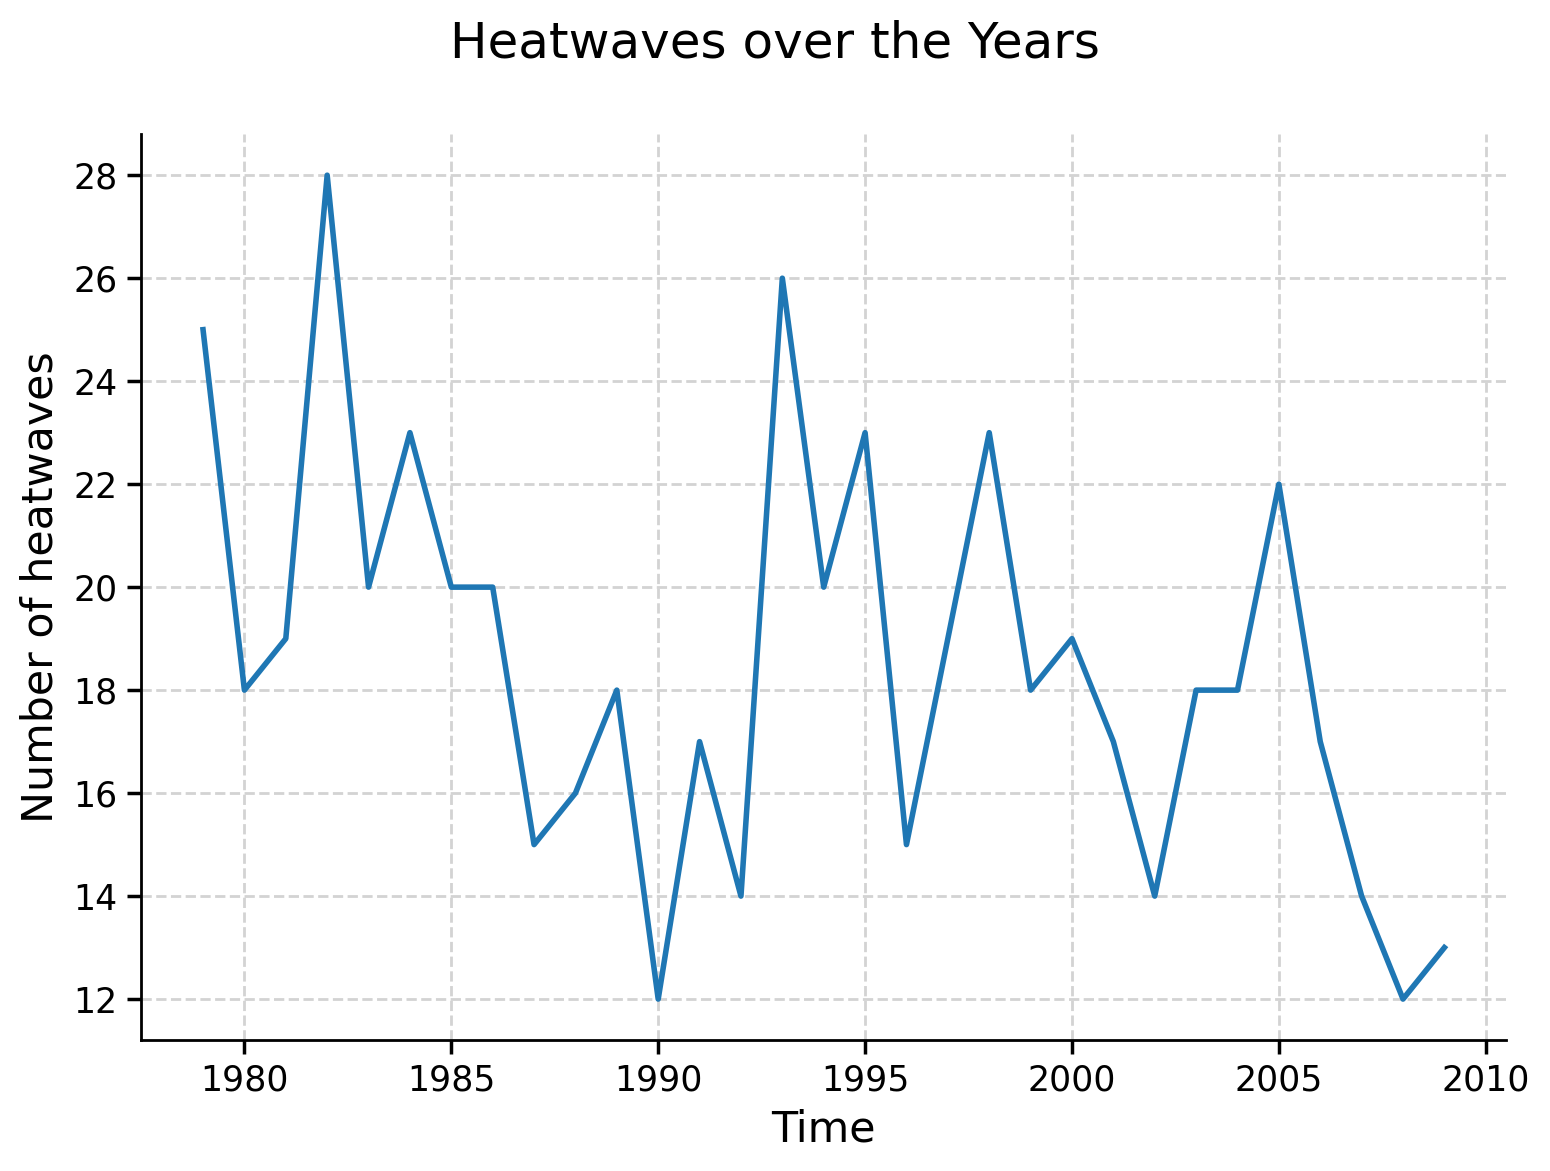

In [34]:
fig, ax = plt.subplots(1, sharex=True)
fig.suptitle("Heatwaves over the Years")
ax.plot(years, hw)
ax.set_ylabel("Number of heatwaves")
ax.set_xlabel("Time")